<a href="https://colab.research.google.com/github/doantronghieu/DEEP-LEARNING/blob/main/UDM_ZTM/MY_CODE/10_TIME_SERIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!wget https://raw.githubusercontent.com/tronghieu2810/DEEP-LEARNING/main/helper_DL.py
!pip install colorama
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':15})
import seaborn           as sns
sns.set()

--2022-04-13 02:28:31--  https://raw.githubusercontent.com/tronghieu2810/DEEP-LEARNING/main/helper_DL.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26763 (26K) [text/plain]
Saving to: ‘helper_DL.py’

helper_DL.py        100%[===================>]  26.14K  --.-KB/s    in 0.005s  

2022-04-13 02:28:31 (4.83 MB/s) - ‘helper_DL.py’ saved [26763/26763]



In [2]:
import helper_DL as helper
import csv
from datetime import datetime
import os

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import minmax_scale

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.data as tfd
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

# Downloading and inspecting our Bitcoin historical dataset

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-04-13 02:28:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-04-13 02:28:46 (7.64 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [4]:
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [7]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.squeeze(tf.cast(y_true, dtype=tf.float32))
  y_pred = tf.squeeze(tf.cast(y_pred, dtype=tf.float32))

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": np.round(mae.numpy(), 2),
          "mse": np.round(mse.numpy(), 2),
          "rmse": np.round(rmse.numpy(), 2),
          "mape": np.round(mape.numpy(), 2),
          "mase": np.round(mase.numpy(), 2)}

# Visualizing our Bitcoin historical data with pandas

In [8]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)'])\
                   .rename(columns={'Closing Price (USD)': 'Price'})

bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


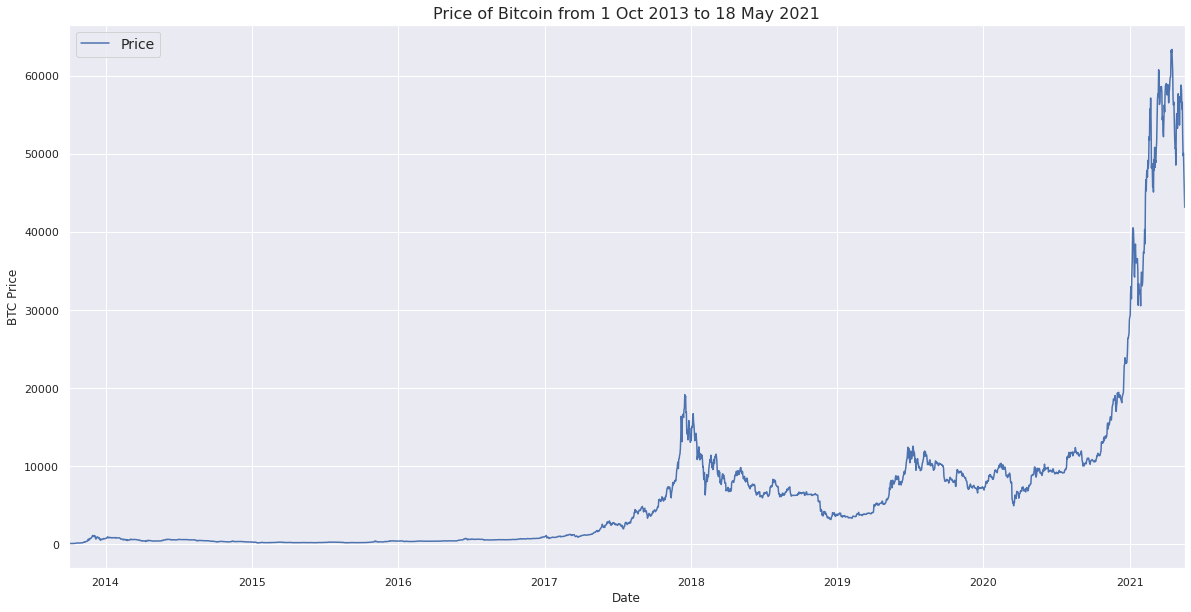

In [9]:
bitcoin_prices.plot(figsize=(20, 10))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14);


# Reading in our Bitcoin data with Python's CSV module

In [10]:
timesteps = []
btc_price = []

with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    next(csv_reader)
    
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
        btc_price.append(float(line[2]))

print(f'{timesteps[:10]}\n')
print(f'{btc_price[:10]}')

[datetime.datetime(2013, 10, 1, 0, 0), datetime.datetime(2013, 10, 2, 0, 0), datetime.datetime(2013, 10, 3, 0, 0), datetime.datetime(2013, 10, 4, 0, 0), datetime.datetime(2013, 10, 5, 0, 0), datetime.datetime(2013, 10, 6, 0, 0), datetime.datetime(2013, 10, 7, 0, 0), datetime.datetime(2013, 10, 8, 0, 0), datetime.datetime(2013, 10, 9, 0, 0), datetime.datetime(2013, 10, 10, 0, 0)]

[123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795, 123.033, 124.049, 125.96116]


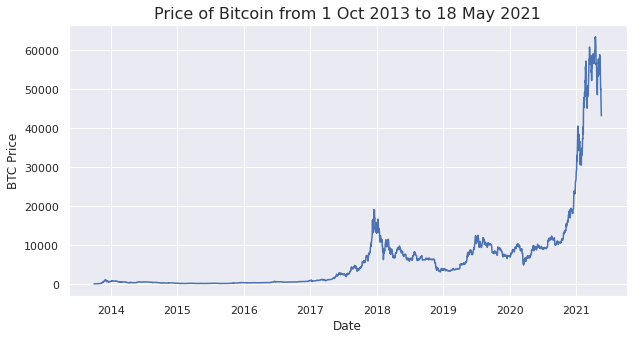

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')
plt.show()

# Creating train and test splits for time series (the wrong way)

In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

print(f'{timesteps[:10]}\n')
print(f'{prices[:10]}\n')

['2013-10-01T00:00:00.000000000' '2013-10-02T00:00:00.000000000'
 '2013-10-03T00:00:00.000000000' '2013-10-04T00:00:00.000000000'
 '2013-10-05T00:00:00.000000000' '2013-10-06T00:00:00.000000000'
 '2013-10-07T00:00:00.000000000' '2013-10-08T00:00:00.000000000'
 '2013-10-09T00:00:00.000000000' '2013-10-10T00:00:00.000000000']

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795
 123.033   124.049   125.96116]



In [13]:
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

print(f'{X_train.shape} - {X_test.shape} - {y_train.shape} - {y_test.shape}')

(2229,) - (558,) - (2229,) - (558,)


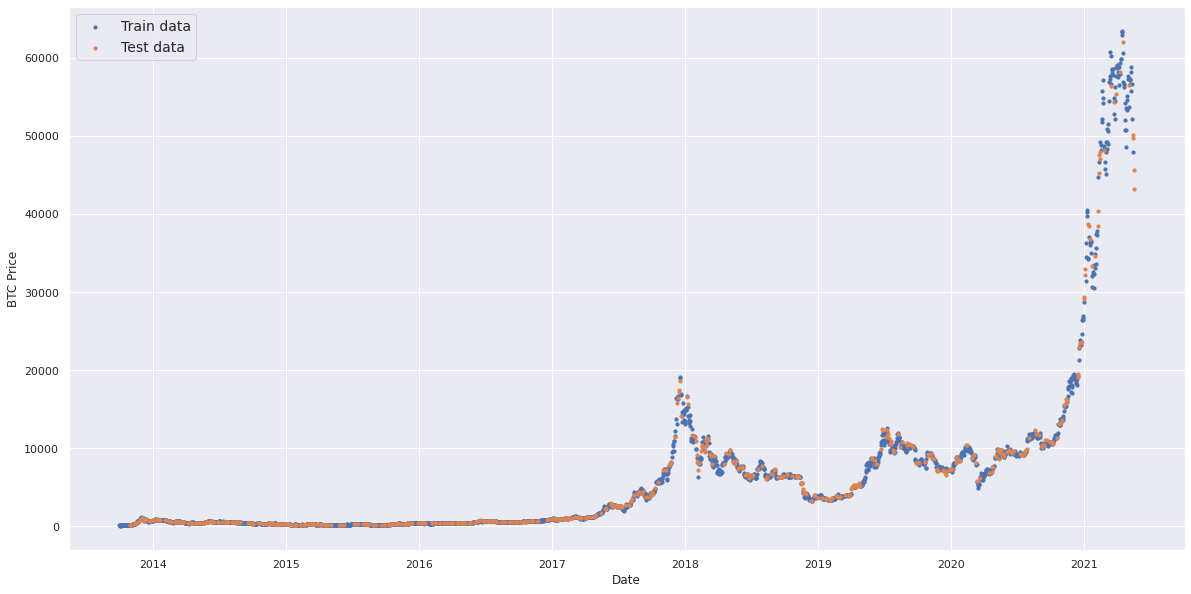

In [14]:
plt.figure(figsize=(20, 10))
plt.scatter(X_train, y_train, s=10, label='Train data')
plt.scatter(X_test, y_test, s=10, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

# Creating train and test splits for time series (the right way)

In [15]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

print(f'{len(X_train)} - {len(X_test)} - {len(y_train)} - {len(y_test)}')

2229 - 558 - 2229 - 558


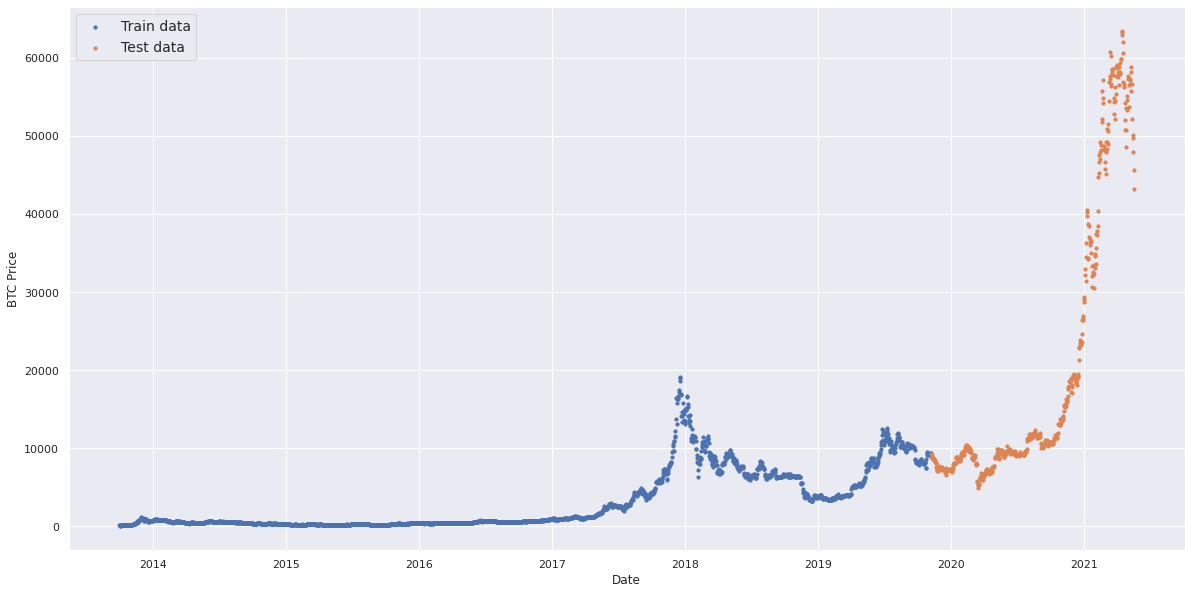

In [16]:
plt.figure(figsize=(20, 10))
plt.scatter(X_train, y_train, s=10, label='Train data')
plt.scatter(X_test, y_test, s=10, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

# Creating a plotting function to visualize our time series data

In [17]:
def plot_time_series(timesteps, values, y_label, format='.',  
                     start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) againts values (a series of
    values across timesteps)

    Parameters:
        timesteps: array of timestep values
        values: array of values across time
        format: style of plot, default '.'
        start: where to start the plot (setting the value will index from start
               of timestep)
        end: where to end the plot
        label: label to show on plot about values
    """
    
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel(y_label)
    if label:
        plt.legend(fontsize=14)

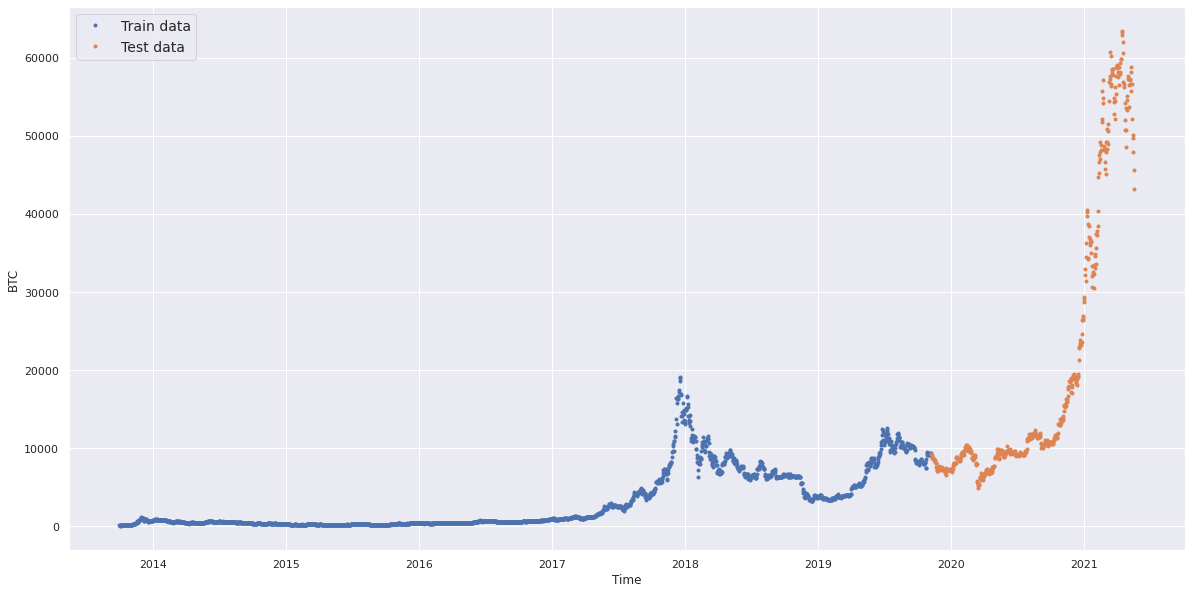

In [18]:
plt.figure(figsize=(20, 10))
plot_time_series(timesteps=X_train, values=y_train, y_label='BTC', format='.',  
                     start=0, end=None, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, y_label='BTC', format='.',  
                     start=0, end=None, label='Test data')

# Formatting data Part 2: Creating a function to label our windowed time series

In [19]:
HORIZON = 1 
WINDOW_SIZE = 7

In [20]:
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.
    """

    output_window = x[:, :-horizon]
    output_horizon = x[:, -horizon:]

    return output_window, output_horizon

In [21]:
print(tf.range(8))
print(tf.range(8) + 1)
print(tf.expand_dims(tf.range(8) + 1, axis=0), '\n')

test = tf.expand_dims(tf.range(8) + 1, axis=0)
test_window, test_label = get_labelled_windows(test)
print(f'Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}')

tf.Tensor([0 1 2 3 4 5 6 7], shape=(8,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7 8], shape=(8,), dtype=int32)
tf.Tensor([[1 2 3 4 5 6 7 8]], shape=(1, 8), dtype=int32) 

Window: [1 2 3 4 5 6 7] -> Label: 8


# Writing a preprocessing function to turn time series data into windows & labels

In [22]:
test_window_size = 7
test_horizon = 1
test 
print(np.arange(test_window_size + test_horizon))
print(np.expand_dims(np.arange(test_window_size + test_horizon), axis=0), '\n')

print()

[0 1 2 3 4 5 6 7]
[[0 1 2 3 4 5 6 7]] 




In [23]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of 
    window_size with horizon size labels.
    """    

    # 1. Create a window of specific window_size (add the horizon on the end
    # for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T

    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return np.round(windows, 3), np.round(labels, 3)    

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(f'{full_windows.shape} - {full_labels.shape}\n')

# View the first 3 windows/labels
for i in range(3):
    print(f'Window: {full_windows[i]} -> Label: {full_labels[i]}')
print()

# View the last 3 windows/labels
for i in range(3):
    print(f'Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}')


(2780, 7) - (2780, 1)

Window: [123.655 125.455 108.585 118.675 121.339 120.655 121.795] -> Label: [123.033]
Window: [125.455 108.585 118.675 121.339 120.655 121.795 123.033] -> Label: [124.049]
Window: [108.585 118.675 121.339 120.655 121.795 123.033 124.049] -> Label: [125.961]

Window: [58788.21  58102.191 55715.547 56573.555 52147.821 49764.132 50032.693] -> Label: [47885.625]
Window: [58102.191 55715.547 56573.555 52147.821 49764.132 50032.693 47885.625] -> Label: [45604.616]
Window: [55715.547 56573.555 52147.821 49764.132 50032.693 47885.625 45604.616] -> Label: [43144.471]


# Turning our windowed time series data into training and test sets

In [25]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matchingt parts of windows and labels into train and test splits.
    """

    split_size = int(len(windows) * (1 - test_split))

    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels

In [26]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, 
                                                                                labels=full_labels, 
                                                                                test_split=0.2)

print(f'{len(train_windows)} - {len(test_windows)} - {len(train_labels)} - {len(test_labels)}')
print(f'{train_windows.shape} - {test_windows.shape} - {train_labels.shape} - {test_labels.shape}\n')



2224 - 556 - 2224 - 556
(2224, 7) - (556, 7) - (2224, 1) - (556, 1)



# Creating a modelling checkpoint callback to save our best performing model

In [27]:
def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tfk.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,
                                                               model_name),
                                                               verbose=0,
                                                               save_best_only=True)

# Model 1: Building, compiling and fitting a deep learning model on Bitcoin data

In [28]:
tf.random.set_seed(42)

model_1 = tfk.Sequential([layers.Dense(128, activation='relu'),
                          layers.Dense(HORIZON, activation='linear')],
                         name='model_1_dense')

model_1.compile(loss='mae',
                optimizer=optimizers.Adam(),
                metrics=['mae', 'mse'])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 7s 121ms/step - loss: 780.3454 - mae: 780.3454 - mse: 2312725.7500 - val_loss: 2279.6526 - val_mae: 2279.6526 - val_mse: 12772728.0000
Epoch 2/100
18/18 [==============================] - 1s 84ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1562 - val_loss: 1005.9991 - val_mae: 1005.9991 - val_mse: 3441833.0000
Epoch 3/100
18/18 [==============================] - 1s 78ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.5781 - val_loss: 923.2873 - val_mae: 923.2873 - val_mse: 2868228.5000
Epoch 4/100
18/18 [==============================] - 1s 86ms/step - loss: 169.4341 - mae: 169.4341 - mse: 151700.7188 - val_loss: 900.5859 - val_mae: 900.5859 - val_mse: 2683713.2500
Epoch 5/100
18/18 [==============================] - 2s 99ms/step - loss: 165.0893 - mae: 165.0893 - mse: 145490.6406 - val_loss: 895.2202 - val_mae: 895.2202 - val_mse: 2564563.7500
Epoch 6/100
18/18 [==============================] - 1s 87ms/step - loss: 158.

In [29]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 616.3101 - mae: 616.3101 - mse: 1258577.5000


[616.3101196289062, 616.3101196289062, 1258577.5]

In [30]:
model_1 = tfk.models.load_model('/content/model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.7739 - mae: 568.7739 - mse: 1174340.6250


[568.77392578125, 568.77392578125, 1174340.625]

# Creating a function to make predictions with our trained models

In [31]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.
    """

    forecast = model.predict(input_data)

    return tf.squeeze(forecast)

In [32]:
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(y_true=test_labels, y_pred=model_1_preds)

print(f'{len(model_1_preds)}\n')
print(f'{tf.squeeze(test_labels[:10])}\n')
print(f'{model_1_preds[:10]}\n')
print(f'{model_1_results}\n')

556

[8798.042 9081.187 8711.534 8760.893 8749.521 8656.971 8500.644 8469.261
 8537.34  8205.806]

[8879.     8787.102  9031.918  8812.3955 8739.545  8746.4795 8704.716
 8513.17   8476.987  8531.78  ]

{'mae': 568.77, 'mse': 1174340.6, 'rmse': 1083.67, 'mape': 2.55, 'mase': 1.0}



In [33]:
print(test_windows.shape)
print(test_labels.shape)

(556, 7)
(556, 1)


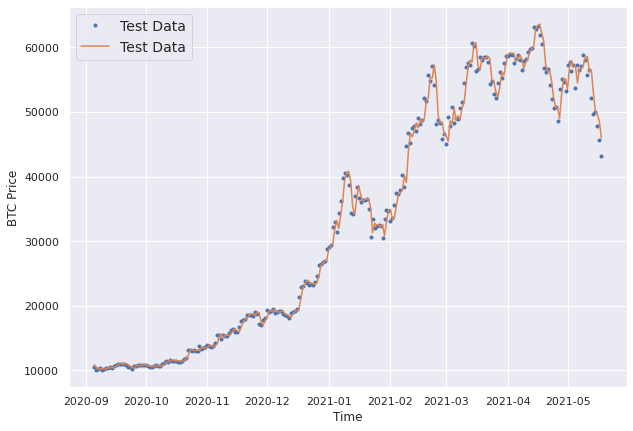

In [34]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='Test Data', 
                 y_label='BTC Price')
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 start=offset, 
                 label='Test Data', 
                 y_label='BTC Price',
                 format='-')

# Model 2: Building, fitting and evaluating a deep model with a larger window size

In [35]:
HORIZON = 1
WINDOW_SIZE = 30

In [36]:
full_windows, full_labels = make_windows(prices, 
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

print(f'{full_windows}')
print(f'{full_windows.shape}\n')
print(f'{full_labels}')
print(f'{full_labels.shape}')

[[  123.655   125.455   108.585 ...   187.16    192.757   197.4  ]
 [  125.455   108.585   118.675 ...   192.757   197.4     196.025]
 [  108.585   118.675   121.339 ...   197.4     196.025   198.049]
 ...
 [63346.789 61965.783 60574.445 ... 52147.821 49764.132 50032.693]
 [61965.783 60574.445 56850.83  ... 49764.132 50032.693 47885.625]
 [60574.445 56850.83  56224.102 ... 50032.693 47885.625 45604.616]]
(2757, 30)

[[  196.025]
 [  198.049]
 [  198.932]
 ...
 [47885.625]
 [45604.616]
 [43144.471]]
(2757, 1)


In [37]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

print(f'{train_windows.shape} - {test_windows.shape} - {train_labels.shape} - {test_labels.shape}')

(2205, 30) - (552, 30) - (2205, 1) - (552, 1)


In [38]:
tf.random.set_seed(42)

model_2 = tfk.Sequential([layers.Dense(128, activation='relu'),
                          layers.Dense(HORIZON, activation='linear')],
                         name='model_2_dense')

model_2.compile(loss='mae',
                optimizer=optimizers.Adam(),
                metrics=['mae', 'mse'])

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [39]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 734.8046 - mae: 734.8046 - mse: 1602063.7500


[734.8045654296875, 734.8045654296875, 1602063.75]

In [40]:
model_2 = tfk.models.load_model('/content/model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 609.3742 - mae: 609.3742 - mse: 1286932.5000


[609.3742065429688, 609.3742065429688, 1286932.5]

In [41]:
model_2_preds = make_preds(model_2, input_data=test_windows)
model_2_results = evaluate_preds(y_true=test_labels, y_pred=model_2_preds)

print(model_2_results)
print(model_1_results)

{'mae': 609.37, 'mse': 1286932.5, 'rmse': 1134.43, 'mape': 2.74, 'mase': 1.07}
{'mae': 568.77, 'mse': 1174340.6, 'rmse': 1083.67, 'mape': 2.55, 'mase': 1.0}


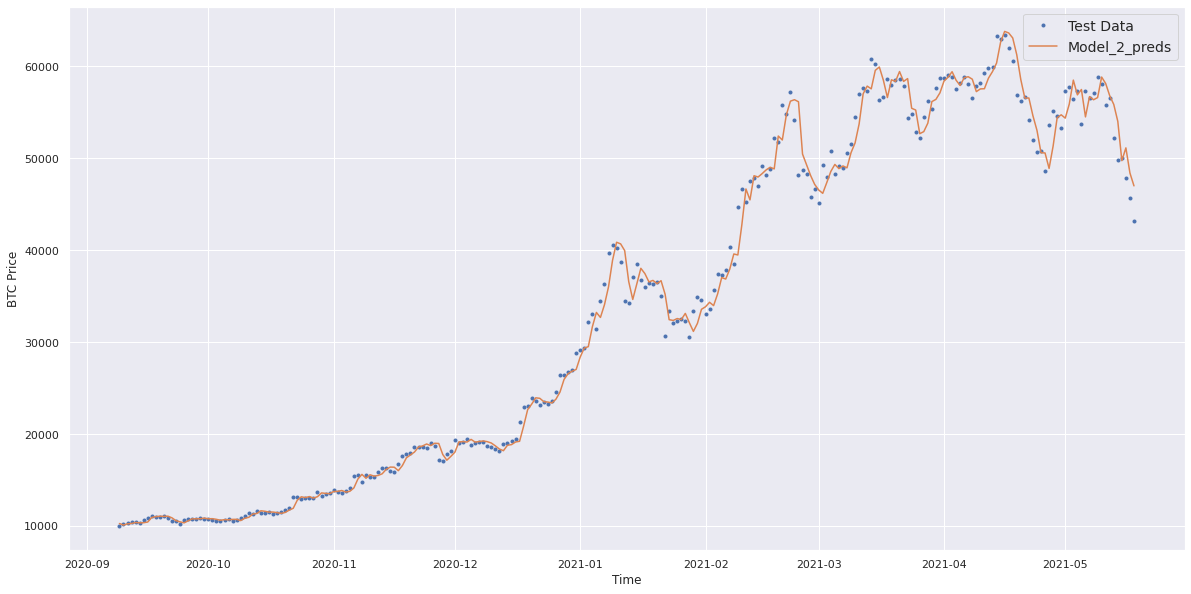

In [42]:
offset = 300
plt.figure(figsize=(20, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label='Test Data',
                 y_label='BTC Price')
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 label='Model_2_preds',
                 y_label='BTC Price',
                 format='-')

# Model 3: Building, fitting and evaluating a model with a larger horizon size

In [43]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, \
    train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

print(len(full_windows), len(full_labels))
print(len(train_windows), len(test_windows), len(train_labels), len(test_labels))

2751 2751
2200 551 2200 551


In [44]:
tf.random.set_seed(42)

model_3 = tfk.Sequential([layers.Dense(128, activation='relu'),
                          layers.Dense(HORIZON)],
                         name='model_3_dense')

model_3.compile(loss='mae',
                optimizer=optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [45]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1325.1086


1325.108642578125

In [46]:
model_3 = tfk.models.load_model('/content/model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1234.6217


1234.6217041015625

In [47]:
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_results = evaluate_preds(y_true=test_labels, y_pred=model_3_preds)

print(model_3_results['mae'].shape, model_3_results['mae'].ndim)
print(model_2_results['mae'].shape, model_2_results['mae'].ndim)

(551,) 1
() 0


# Adjusting the evaluation function to work for predictions with larger horizons

In [48]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.squeeze(tf.cast(y_true, dtype=tf.float32))
    y_pred = tf.squeeze(tf.cast(y_pred, dtype=tf.float32))

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
  
    if (mae.ndim > 0):
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": np.round(mae.numpy(), 2),
            "mse": np.round(mse.numpy(), 2),
            "rmse": np.round(rmse.numpy(), 2),
            "mape": np.round(mape.numpy(), 2),
            "mase": np.round(mase.numpy(), 2)}

In [49]:
model_3_results = evaluate_preds(y_true=test_labels, y_pred=model_3_preds)

print(model_3_results)

{'mae': 1234.62, 'mse': 5377565.5, 'rmse': 1420.3, 'mape': 5.51, 'mase': 2.2}


# Model 3: Visualizing the results

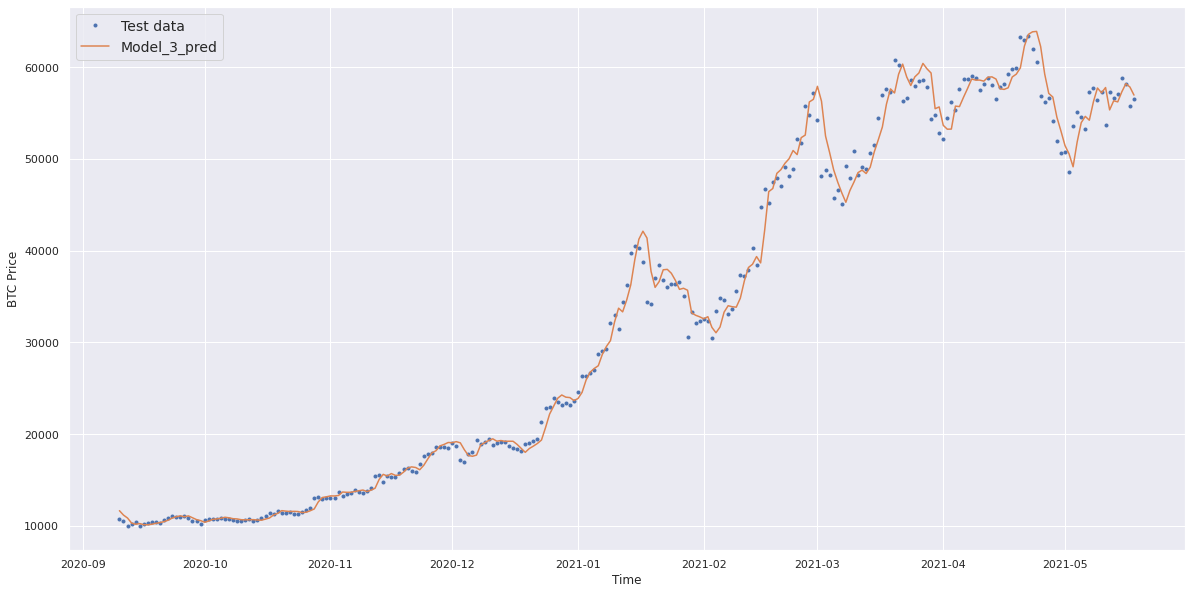

In [50]:
offset = 300
plt.figure(figsize=(20, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label='Test data',
                 y_label='BTC Price')
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 label='Model_3_pred',
                 y_label='BTC Price',
                 format='-')


# Comparing our modelling experiments so far and discussing autocorrelation

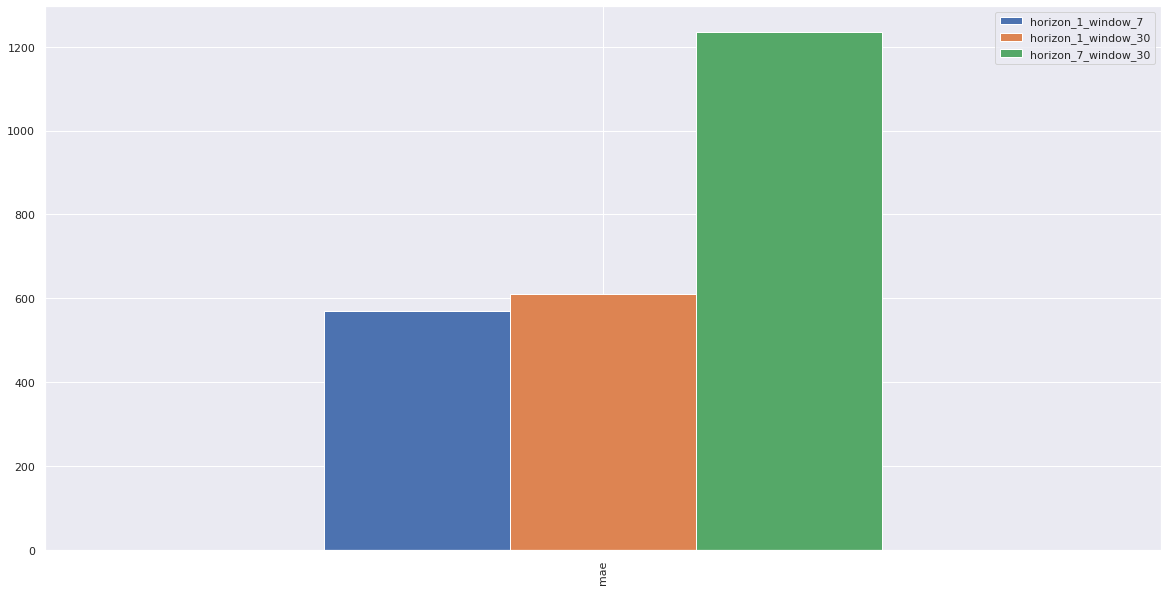

In [51]:
pd.DataFrame({'horizon_1_window_7': model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']},
             index=['mae']).plot.bar(figsize=(20, 10));

# Preparing data for building a Conv1D model

In [52]:
HORIZON = 1
WINDOW_SIZE = 7

In [53]:
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)

print(f'{len(full_windows)} - {len(full_labels)}')

2780 - 2780


In [54]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

print(f'{train_windows.shape} - {train_labels.shape} - {test_windows.shape} - {test_labels.shape}')

(2224, 7) - (2224, 1) - (556, 7) - (556, 1)


In [55]:
x = tf.constant(train_windows[0])

expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

print(x, '\n')
print(expand_dims_layer(x))

tf.Tensor([123.655 125.455 108.585 118.675 121.339 120.655 121.795], shape=(7,), dtype=float64) 

tf.Tensor(
[[123.655]
 [125.455]
 [108.585]
 [118.675]
 [121.339]
 [120.655]
 [121.795]], shape=(7, 1), dtype=float32)


# Model 4: Building, fitting and evaluating a Conv1D model on our Bitcoin data

In [56]:
tf.random.set_seed(42)

model_4 = tfk.Sequential([layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                          layers.Conv1D(filters=128, kernel_size=5, 
                                        strides=1, padding='causal',
                                        activation='relu'),
                          layers.Dense(HORIZON)],
                         name='model_4_conv1D')

model_4.compile(loss='mae',
                optimizer=optimizers.Adam())

model_4.fit(train_windows, train_labels, batch_size=128, epochs=100, verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [57]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 616.1907


616.1907348632812

In [60]:
model_4 = tfk.models.load_model('/content/model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.7609


568.7608642578125

In [61]:
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_preds(y_true=test_labels, y_pred=model_4_preds)

print(model_4_preds), print()
print(model_4_results)

tf.Tensor(
[ 8863.204   8772.258   9011.019   8777.561   8722.963   8728.275
  8675.253   8511.488   8453.811   8513.017   8256.58    8109.8755
  8059.8193  7687.9487  7308.58    7282.149   7094.9365  7172.8447
  7139.349   7445.301   7427.608   7681.996   7603.7437  7423.74
  7327.8467  7313.882   7224.3257  7346.8477  7486.089   7540.49
  7551.2227  7373.906   7249.1777  7192.7563  7182.3384  7216.4263
  7102.871   7094.58    6914.4707  6625.29    7246.782   7226.4707
  7151.477   7236.115   7277.052   7200.837   7207.7197  7217.5737
  7186.7217  7208.5625  7293.7754  7379.704   7278.1436  7184.1025
  7166.5806  6990.291   7213.949   7327.782   7358.592   7653.199
  8028.115   8134.478   7886.088   8048.192   8116.705   8159.9517
  8116.756   8637.275   8889.827   8785.648   8903.417   8978.218
  8726.505   8629.556   8687.75    8647.514   8411.504   8415.345
  8356.682   8513.17    8820.489   9119.437   9336.226   9558.147
  9478.725   9398.111   9389.697   9296.154   9181.874   952

# Model 5: Building, fitting and evaluating a LSTM (RNN) model on our Bitcoin data

In [62]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tfk.Model(inputs=inputs, outputs=outputs, name='model_5_LSTM')

model_5.compile(loss='mae',
                optimizer=optimizers.Adam())
model_5.fit(train_windows, train_labels, epochs=100, verbose=1, batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 2475.4353INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 5s 182ms/step - loss: 2323.6082 - val_loss: 9222.7285
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 776.7184 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 149ms/step - loss: 695.4736 - val_loss: 1485.4932
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 251.2238INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 147ms/step - loss: 237.3473 - val_loss: 1292.1003
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 186.0066INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 145ms/step - loss: 181.6847 - val_loss: 966.5322
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 173.3528 - val_loss: 970.4850
Epoch 6/100
15/18 [========================>.....] - ETA: 0s - loss: 178.2632INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 167ms/step - loss: 177.4095 - val_loss: 931.6276
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 169.2040 - val_loss: 961.1178
Epoch 8/100
18/18 [==============================] - 0s 10ms/step - loss: 169.8476 - val_loss: 964.7736
Epoch 9/100
18/18 [==============================] - 0s 11ms/step - loss: 166.4371 - val_loss: 951.4073
Epoch 10/100
18/18 [==============================] - 0s 13ms/step - loss: 167.0309 - val_loss: 1037.4885
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 163.8421INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 197ms/step - loss: 163.2047 - val_loss: 867.7862
Epoch 12/100
18/18 [==============================] - 0s 25ms/step - loss: 160.3589 - val_loss: 881.2701
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 153.5316INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 181ms/step - loss: 153.5316 - val_loss: 845.4414
Epoch 14/100
18/18 [==============================] - 0s 12ms/step - loss: 149.2831 - val_loss: 894.6898
Epoch 15/100
18/18 [==============================] - 0s 10ms/step - loss: 149.7149 - val_loss: 859.3569
Epoch 16/100
18/18 [==============================] - 0s 10ms/step - loss: 163.5536 - val_loss: 870.8191
Epoch 17/100
18/18 [==============================] - 0s 10ms/step - loss: 159.3771 - val_loss: 916.5750
Epoch 18/100
18/18 [==============================] - 0s 10ms/step - loss: 158.3934 - val_loss: 917.4592
Epoch 19/100
18/18 [==============================] - 0s 11ms/step - loss: 156.6654 - val_loss: 924.0630
Epoch 20/100
15/18 [========================>.....] - ETA: 0s - loss: 158.6433INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 175ms/step - loss: 154.7237 - val_loss: 810.3993
Epoch 21/100
18/18 [==============================] - 0s 11ms/step - loss: 159.9604 - val_loss: 884.3584
Epoch 22/100
18/18 [==============================] - 0s 11ms/step - loss: 160.2957 - val_loss: 887.8359
Epoch 23/100
18/18 [==============================] - 0s 11ms/step - loss: 157.9625 - val_loss: 907.1389
Epoch 24/100
18/18 [==============================] - 0s 10ms/step - loss: 154.0541 - val_loss: 902.9102
Epoch 25/100
18/18 [==============================] - 0s 11ms/step - loss: 152.4523 - val_loss: 878.4426
Epoch 26/100
18/18 [==============================] - 0s 11ms/step - loss: 151.8452 - val_loss: 865.3160
Epoch 27/100
18/18 [==============================] - 0s 11ms/step - loss: 149.1810 - val_loss: 846.6711
Epoch 28/100
18/18 [==============================] - 0s 11ms/step - loss: 147.9135 - val_loss: 833.6843
Epoch 29/100
18/18 [==============================] - 0s 11ms/step 

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 154ms/step - loss: 143.4726 - val_loss: 797.4728
Epoch 32/100
18/18 [==============================] - 0s 10ms/step - loss: 142.3151 - val_loss: 797.6758
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 142.0769 - val_loss: 861.5551
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 148.1014INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 152ms/step - loss: 141.8969 - val_loss: 771.0344
Epoch 35/100
18/18 [==============================] - 0s 10ms/step - loss: 138.1103 - val_loss: 784.7657
Epoch 36/100
14/18 [======================>.......] - ETA: 0s - loss: 137.6038INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 148ms/step - loss: 137.9660 - val_loss: 757.5908
Epoch 37/100
18/18 [==============================] - 0s 10ms/step - loss: 135.2673 - val_loss: 762.5453
Epoch 38/100
14/18 [======================>.......] - ETA: 0s - loss: 138.1619INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 172ms/step - loss: 133.4635 - val_loss: 744.5865
Epoch 39/100
18/18 [==============================] - 0s 11ms/step - loss: 133.1243 - val_loss: 750.8017
Epoch 40/100
18/18 [==============================] - 0s 11ms/step - loss: 135.9392 - val_loss: 776.4354
Epoch 41/100
13/18 [====================>.........] - ETA: 0s - loss: 139.7681INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 150ms/step - loss: 133.6028 - val_loss: 734.8065
Epoch 42/100
18/18 [==============================] - 0s 11ms/step - loss: 133.7810 - val_loss: 766.7113
Epoch 43/100
13/18 [====================>.........] - ETA: 0s - loss: 126.2066INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 151ms/step - loss: 129.6153 - val_loss: 716.9560
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 125.9184INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 154ms/step - loss: 129.4800 - val_loss: 712.0938
Epoch 45/100
14/18 [======================>.......] - ETA: 0s - loss: 122.5407INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 177ms/step - loss: 127.3661 - val_loss: 705.7771
Epoch 46/100
18/18 [==============================] - 0s 11ms/step - loss: 127.5033 - val_loss: 707.5152
Epoch 47/100
18/18 [==============================] - 0s 10ms/step - loss: 125.1460 - val_loss: 714.8968
Epoch 48/100
18/18 [==============================] - 0s 11ms/step - loss: 124.8036 - val_loss: 705.9467
Epoch 49/100
18/18 [==============================] - ETA: 0s - loss: 126.1843INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 151ms/step - loss: 126.1843 - val_loss: 689.0979
Epoch 50/100
18/18 [==============================] - 0s 11ms/step - loss: 125.2972 - val_loss: 722.0735
Epoch 51/100
18/18 [==============================] - 0s 10ms/step - loss: 127.0892 - val_loss: 788.2820
Epoch 52/100
18/18 [==============================] - 0s 11ms/step - loss: 127.1419 - val_loss: 691.0000
Epoch 53/100
15/18 [========================>.....] - ETA: 0s - loss: 124.0519INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 152ms/step - loss: 124.2787 - val_loss: 683.9645
Epoch 54/100
15/18 [========================>.....] - ETA: 0s - loss: 123.9060INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 5s 277ms/step - loss: 122.6222 - val_loss: 668.9981
Epoch 55/100
16/18 [=========================>....] - ETA: 0s - loss: 123.2042INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 6s 375ms/step - loss: 120.2685 - val_loss: 661.6437
Epoch 56/100
18/18 [==============================] - 0s 21ms/step - loss: 123.8663 - val_loss: 672.4765
Epoch 57/100
18/18 [==============================] - 0s 18ms/step - loss: 122.8051 - val_loss: 683.7921
Epoch 58/100
18/18 [==============================] - ETA: 0s - loss: 119.2697INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 6s 360ms/step - loss: 119.2697 - val_loss: 652.1493
Epoch 59/100
18/18 [==============================] - ETA: 0s - loss: 118.1555INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 201ms/step - loss: 118.1555 - val_loss: 649.4571
Epoch 60/100
18/18 [==============================] - 0s 10ms/step - loss: 118.2263 - val_loss: 651.4708
Epoch 61/100
18/18 [==============================] - 0s 10ms/step - loss: 118.1318 - val_loss: 678.8654
Epoch 62/100
18/18 [==============================] - 0s 10ms/step - loss: 121.3269 - val_loss: 724.1062
Epoch 63/100
18/18 [==============================] - 0s 11ms/step - loss: 122.3745 - val_loss: 653.4904
Epoch 64/100
18/18 [==============================] - 0s 10ms/step - loss: 116.5862 - val_loss: 672.2280
Epoch 65/100
15/18 [========================>.....] - ETA: 0s - loss: 116.8959INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 169ms/step - loss: 118.3137 - val_loss: 636.7775
Epoch 66/100
18/18 [==============================] - 0s 10ms/step - loss: 117.0657 - val_loss: 644.1871
Epoch 67/100
14/18 [======================>.......] - ETA: 0s - loss: 118.8737INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 148ms/step - loss: 116.9880 - val_loss: 631.7178
Epoch 68/100
18/18 [==============================] - 0s 12ms/step - loss: 116.4154 - val_loss: 633.4936
Epoch 69/100
18/18 [==============================] - 0s 11ms/step - loss: 120.7427 - val_loss: 633.2463
Epoch 70/100
18/18 [==============================] - ETA: 0s - loss: 115.2283INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 151ms/step - loss: 115.2283 - val_loss: 626.4765
Epoch 71/100
18/18 [==============================] - 0s 11ms/step - loss: 115.6732 - val_loss: 651.0785
Epoch 72/100
18/18 [==============================] - 0s 11ms/step - loss: 119.4823 - val_loss: 634.5302
Epoch 73/100
18/18 [==============================] - 0s 12ms/step - loss: 116.7772 - val_loss: 632.7021
Epoch 74/100
18/18 [==============================] - 0s 11ms/step - loss: 115.7893 - val_loss: 633.7025
Epoch 75/100
18/18 [==============================] - 0s 11ms/step - loss: 116.4430 - val_loss: 661.9423
Epoch 76/100
14/18 [======================>.......] - ETA: 0s - loss: 117.5314INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 146ms/step - loss: 116.0921 - val_loss: 617.3766
Epoch 77/100
18/18 [==============================] - 0s 11ms/step - loss: 114.8838 - val_loss: 677.2085
Epoch 78/100
18/18 [==============================] - 0s 11ms/step - loss: 117.8279 - val_loss: 646.6225
Epoch 79/100
13/18 [====================>.........] - ETA: 0s - loss: 112.2958INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 173ms/step - loss: 114.9848 - val_loss: 616.4899
Epoch 80/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5371 - val_loss: 621.0123
Epoch 81/100
18/18 [==============================] - 0s 10ms/step - loss: 114.2723 - val_loss: 643.4786
Epoch 82/100
18/18 [==============================] - 0s 11ms/step - loss: 117.1167 - val_loss: 622.2340
Epoch 83/100
18/18 [==============================] - 0s 11ms/step - loss: 113.7279 - val_loss: 643.5879
Epoch 84/100
18/18 [==============================] - 0s 10ms/step - loss: 115.4718 - val_loss: 625.3492
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 113.4685 - val_loss: 631.9392
Epoch 86/100
18/18 [==============================] - 0s 11ms/step - loss: 114.9300 - val_loss: 619.2437
Epoch 87/100
14/18 [======================>.......] - ETA: 0s - loss: 116.8197INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 150ms/step - loss: 112.9464 - val_loss: 607.1457
Epoch 88/100
14/18 [======================>.......] - ETA: 0s - loss: 116.8223INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 150ms/step - loss: 112.3964 - val_loss: 605.6954
Epoch 89/100
18/18 [==============================] - 0s 11ms/step - loss: 112.2668 - val_loss: 635.6979
Epoch 90/100
18/18 [==============================] - 0s 10ms/step - loss: 117.1740 - val_loss: 646.6083
Epoch 91/100
18/18 [==============================] - 0s 10ms/step - loss: 115.4887 - val_loss: 624.1168
Epoch 92/100
18/18 [==============================] - 0s 11ms/step - loss: 113.3707 - val_loss: 610.8763
Epoch 93/100
14/18 [======================>.......] - ETA: 0s - loss: 114.8131INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 169ms/step - loss: 112.9680 - val_loss: 601.5749
Epoch 94/100
18/18 [==============================] - 0s 10ms/step - loss: 111.5477 - val_loss: 604.9694
Epoch 95/100
15/18 [========================>.....] - ETA: 0s - loss: 111.4628INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 149ms/step - loss: 111.5862 - val_loss: 599.7866
Epoch 96/100
18/18 [==============================] - 0s 11ms/step - loss: 113.0798 - val_loss: 607.2055
Epoch 97/100
18/18 [==============================] - 0s 10ms/step - loss: 112.3658 - val_loss: 633.5398
Epoch 98/100
18/18 [==============================] - 0s 11ms/step - loss: 112.6939 - val_loss: 601.4340
Epoch 99/100
14/18 [======================>.......] - ETA: 0s - loss: 108.7594INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 152ms/step - loss: 111.1543 - val_loss: 597.3178
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 112.6476 - val_loss: 597.6377


In [63]:
model_5 = tfk.models.load_model('/content/model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 597.3177


597.3177490234375

In [64]:
model_5_preds = make_preds(model_5, test_windows)
model_5_results = evaluate_preds(y_true=test_labels, y_pred=model_5_preds)

print(model_5_preds), print()
print(model_5_results)

tf.Tensor(
[ 8985.648   8812.81    8992.642   8841.683   8732.47    8773.4375
  8737.575   8542.73    8504.275   8530.878   8328.818   8154.929
  8098.2705  7786.0337  7358.399   7275.264   7116.91    7112.567
  7137.8     7418.032   7438.0376  7669.6904  7635.2827  7511.155
  7363.8955  7368.2456  7245.695   7337.4355  7488.5674  7553.62
  7569.2593  7455.969   7308.4224  7229.021   7206.567   7216.9316
  7148.648   7122.309   6978.107   6706.0386  7134.1504  7254.771
  7164.372   7242.703   7360.7275  7194.9546  7235.1675  7256.536
  7213.214   7229.172   7312.6924  7384.5654  7323.433   7237.2485
  7205.7607  7053.81    7181.6875  7330.957   7374.95    7604.3657
  7997.528   8112.635   7951.426   8070.2485  8140.1855  8161.0264
  8136.1963  8585.693   8845.026   8820.446   8904.125   9033.439
  8790.759   8667.086   8728.536   8682.396   8465.49    8451.511
  8403.62    8502.78    8774.266   9091.661   9300.642   9548.012
  9529.759   9447.777   9432.332   9359.456   9222.258   9495

# Investigating how to turn our univariate time series into multivariate

In [65]:
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [66]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-18')

# Creating and plotting a multivariate time series with BTC price and block reward

In [67]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

print(block_reward_2_days, ' - ', block_reward_3_days)

1012  -  2421


In [68]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4


bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


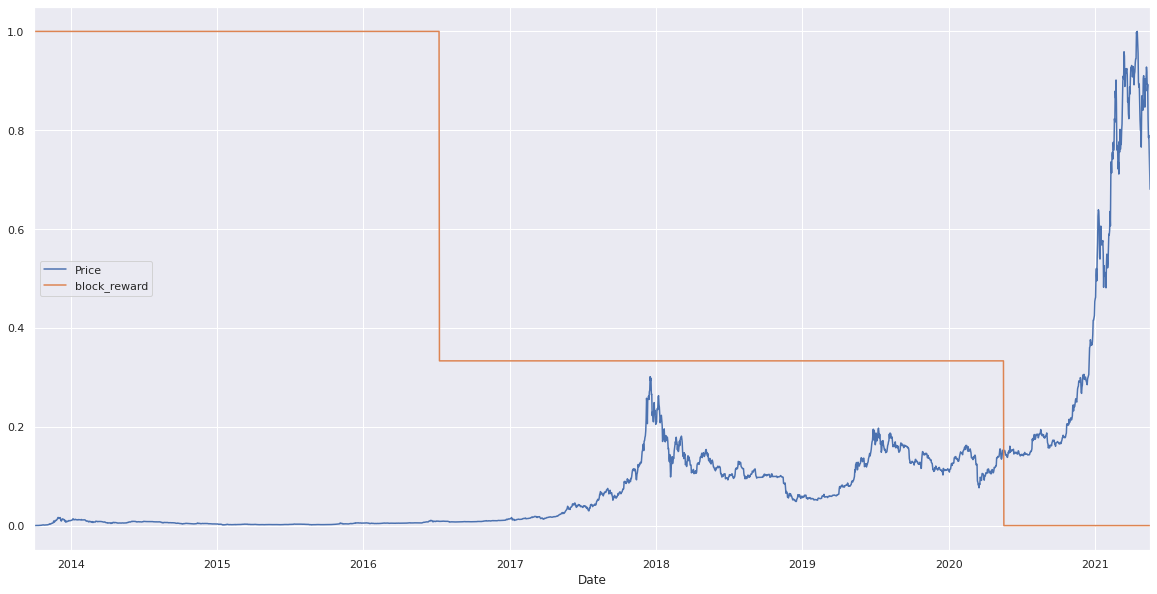

In [69]:
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(20, 10));

# Preparing our multivariate time series for a model

In [70]:
HORIZON = 1
WINDOW_SIZE = 7

In [71]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()
print(bitcoin_prices_windowed), print()

for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price']\
                                                .shift(periods=i+1)
bitcoin_prices_windowed


                   Price block_reward
Date                                 
2013-10-01    123.654990           25
2013-10-02    125.455000           25
2013-10-03    108.584830           25
2013-10-04    118.674660           25
2013-10-05    121.338660           25
...                  ...          ...
2021-05-14  49764.132082         6.25
2021-05-15  50032.693137         6.25
2021-05-16  47885.625255         6.25
2021-05-17  45604.615754         6.25
2021-05-18  43144.471291         6.25

[2787 rows x 2 columns]



,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [72]:
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

In [73]:
X

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.00,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.00,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.00,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.00,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.00,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661
...,...,...,...,...,...,...,...,...
2021-05-14,6.25,52147.820312,56573.554688,55715.546875,58102.191406,58788.210938,57107.121094,56583.851562
2021-05-15,6.25,49764.132812,52147.820312,56573.554688,55715.546875,58102.191406,58788.210938,57107.121094
2021-05-16,6.25,50032.691406,49764.132812,52147.820312,56573.554688,55715.546875,58102.191406,58788.210938


In [74]:
y

Date
2013-10-08      123.032997
2013-10-09      124.049004
2013-10-10      125.961159
2013-10-11      125.279663
2013-10-12      125.927498
                  ...     
2021-05-14    49764.132812
2021-05-15    50032.691406
2021-05-16    47885.625000
2021-05-17    45604.617188
2021-05-18    43144.472656
Name: Price, Length: 2780, dtype: float32

In [75]:
split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

print(X_train.shape, '-', y_train.shape, '-', X_test.shape, '-', y_test.shape)

(2224, 8) - (2224,) - (556, 8) - (556,)


# Model 6: Building, fitting and evaluating a multivariate time series model

In [76]:
tf.random.set_seed(42)

model_6 = tfk.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

model_6.compile(loss='mae',
                optimizer=optimizers.Adam())

model_6.fit(X_train, y_train, epochs=100, batch_size=128, verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 1319.6465INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 72ms/step - loss: 1234.6805 - val_loss: 2061.9080
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 362.2567INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 351.5053 - val_loss: 1908.6729
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 244.0423INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 38ms/step - loss: 235.4153 - val_loss: 1329.0585
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 221.0886INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 39ms/step - loss: 208.6112 - val_loss: 1102.1340
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 196.5770 - val_loss: 1107.8472
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 186.0619INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 38ms/step - loss: 187.2244 - val_loss: 1036.1722
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 182.9338INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 182.0245 - val_loss: 1019.2924
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 174.2125INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 175.7059 - val_loss: 977.8487
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 173.7910INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 170.1784 - val_loss: 954.4034
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 161.9759INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 38ms/step - loss: 164.4430 - val_loss: 913.5146
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 157.0967INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 38ms/step - loss: 158.6892 - val_loss: 874.2504
Epoch 12/100
14/18 [======================>.......] - ETA: 0s - loss: 152.0518INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 152.0732 - val_loss: 861.0414
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 151.1057 - val_loss: 886.1201
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 147.5482INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 147.5482 - val_loss: 837.8613
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 142.5062INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 142.3497 - val_loss: 794.4784
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 137.5206INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 137.5206 - val_loss: 778.4048
Epoch 17/100
17/18 [===========================>..] - ETA: 0s - loss: 135.2092INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 135.8191 - val_loss: 772.4528
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 140.1422INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 134.8562 - val_loss: 747.4800
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 130.3347 - val_loss: 761.0549
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 128.4480INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 128.6775 - val_loss: 701.8977
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 128.7350INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 129.5576 - val_loss: 691.0128
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 127.2178INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 125.8060 - val_loss: 684.4119
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 125.5263 - val_loss: 692.1294
Epoch 24/100
16/18 [=========================>....] - ETA: 0s - loss: 123.2350INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 53ms/step - loss: 122.4765 - val_loss: 674.2213
Epoch 25/100
14/18 [======================>.......] - ETA: 0s - loss: 123.2996INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 38ms/step - loss: 121.1171 - val_loss: 669.6445
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 127.2623 - val_loss: 690.0408
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 124.2509INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 124.6204 - val_loss: 643.9725
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 118.2544 - val_loss: 656.2766
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 119.0562INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 119.6374 - val_loss: 633.4545
Epoch 30/100
16/18 [=========================>....] - ETA: 0s - loss: 117.9797INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 119.5001 - val_loss: 625.3953
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 114.5633 - val_loss: 668.5061
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 117.6070INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 38ms/step - loss: 116.9750 - val_loss: 617.1060
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2438 - val_loss: 649.0985
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 114.5187 - val_loss: 632.1378
Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 113.9084INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 113.6357 - val_loss: 607.4173
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2605 - val_loss: 626.4316
Epoch 37/100
15/18 [========================>.....] - ETA: 0s - loss: 116.2274INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 35ms/step - loss: 113.7021 - val_loss: 606.2318
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 111.5770INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 111.4061 - val_loss: 603.2919
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 112.3873INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 37ms/step - loss: 112.7722 - val_loss: 596.0060
Epoch 40/100
17/18 [===========================>..] - ETA: 0s - loss: 110.8327INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 36ms/step - loss: 110.5418 - val_loss: 593.2170
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8671 - val_loss: 609.1066
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 115.7249 - val_loss: 607.4875
Epoch 43/100
18/18 [==============================] - 0s 11ms/step - loss: 111.3313 - val_loss: 606.2031
Epoch 44/100
15/18 [========================>.....] - ETA: 0s - loss: 108.7434INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 110ms/step - loss: 109.7027 - val_loss: 586.1214
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8748 - val_loss: 593.8447
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8641 - val_loss: 586.4578
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3587 - val_loss: 655.4485
Epoch 48/100
18/18 [==============================] - 0s 9ms/step - loss: 109.1614 - val_loss: 598.7232
Epoch 49/100
18/18 [==============================] - 0s 9ms/step - loss: 109.3029 - val_loss: 589.2487
Epoch 50/100
18/18 [==============================] - 0s 20ms/step - loss: 111.1971 - val_loss: 649.3792
Epoch 51/100
18/18 [==============================] - 0s 9ms/step - loss: 110.8514 - val_loss: 602.7665
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8331 - val_loss: 599.2959
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 58ms/step - loss: 110.4069 - val_loss: 575.7751
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 108.6609 - val_loss: 785.9759
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.9824 - val_loss: 670.3788
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 112.8591 - val_loss: 580.2875
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 107.2513 - val_loss: 597.5087
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 109.2322 - val_loss: 632.2953
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 109.3519 - val_loss: 591.5410
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 108.4084 - val_loss: 617.5808
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5326 - val_loss: 613.1470
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 99ms/step - loss: 112.0475 - val_loss: 575.5543
Epoch 66/100
18/18 [==============================] - 0s 11ms/step - loss: 111.2830 - val_loss: 590.7806
Epoch 67/100
18/18 [==============================] - 0s 17ms/step - loss: 106.7917 - val_loss: 586.8845
Epoch 68/100
18/18 [==============================] - 0s 14ms/step - loss: 112.2987 - val_loss: 696.5294
Epoch 69/100
18/18 [==============================] - 0s 13ms/step - loss: 124.7808 - val_loss: 698.5267
Epoch 70/100
18/18 [==============================] - 0s 11ms/step - loss: 119.3443 - val_loss: 581.2104
Epoch 71/100
18/18 [==============================] - 0s 15ms/step - loss: 109.9960 - val_loss: 607.6739
Epoch 72/100
18/18 [==============================] - ETA: 0s - loss: 106.7710INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 116ms/step - loss: 106.7710 - val_loss: 573.6144
Epoch 73/100
18/18 [==============================] - 0s 14ms/step - loss: 110.2485 - val_loss: 618.8955
Epoch 74/100
18/18 [==============================] - 0s 16ms/step - loss: 105.5330 - val_loss: 574.9454
Epoch 75/100
18/18 [==============================] - 0s 12ms/step - loss: 107.3177 - val_loss: 606.1973
Epoch 76/100
18/18 [==============================] - 0s 11ms/step - loss: 107.8084 - val_loss: 582.2406
Epoch 77/100
17/18 [===========================>..] - ETA: 0s - loss: 108.0617INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 130ms/step - loss: 107.2528 - val_loss: 571.8563
Epoch 78/100
18/18 [==============================] - 0s 16ms/step - loss: 106.2309 - val_loss: 572.2827
Epoch 79/100
18/18 [==============================] - 0s 15ms/step - loss: 105.8568 - val_loss: 596.5464
Epoch 80/100
18/18 [==============================] - 0s 15ms/step - loss: 107.8419 - val_loss: 577.2399
Epoch 81/100
16/18 [=========================>....] - ETA: 0s - loss: 105.0244INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 128ms/step - loss: 105.1101 - val_loss: 568.4897
Epoch 82/100
18/18 [==============================] - 0s 16ms/step - loss: 114.1867 - val_loss: 592.5613
Epoch 83/100
18/18 [==============================] - 0s 14ms/step - loss: 107.9631 - val_loss: 651.6219
Epoch 84/100
18/18 [==============================] - 0s 13ms/step - loss: 109.6690 - val_loss: 568.9339
Epoch 85/100
18/18 [==============================] - 0s 13ms/step - loss: 105.8219 - val_loss: 571.5331
Epoch 86/100
18/18 [==============================] - 0s 14ms/step - loss: 104.8628 - val_loss: 579.3857
Epoch 87/100
18/18 [==============================] - 0s 16ms/step - loss: 104.7148 - val_loss: 582.9182
Epoch 88/100
18/18 [==============================] - 0s 16ms/step - loss: 106.8899 - val_loss: 569.0820
Epoch 89/100
18/18 [==============================] - 0s 15ms/step - loss: 105.4376 - val_loss: 569.3439
Epoch 90/100
18/18 [==============================] - 0s 16ms/step 

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 124ms/step - loss: 104.2910 - val_loss: 568.2687
Epoch 96/100
18/18 [==============================] - 0s 13ms/step - loss: 106.5346 - val_loss: 606.5489
Epoch 97/100
18/18 [==============================] - 0s 15ms/step - loss: 107.1290 - val_loss: 585.3787
Epoch 98/100
18/18 [==============================] - 0s 15ms/step - loss: 105.8151 - val_loss: 574.4833
Epoch 99/100
18/18 [==============================] - ETA: 0s - loss: 105.8276INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 123ms/step - loss: 105.8276 - val_loss: 567.5863
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 114.9743 - val_loss: 654.9892


In [77]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 654.9892


654.9891967773438

In [78]:
model_6 = tfk.models.load_model('/content/model_experiments/model_6_dense_multivariate')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 567.5862


567.5862426757812

In [79]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)

print(model_6_results)
print(model_1_results)

{'mae': 567.59, 'mse': 1161687.2, 'rmse': 1077.82, 'mape': 2.54, 'mase': 1.0}
{'mae': 568.77, 'mse': 1174340.6, 'rmse': 1083.67, 'mape': 2.55, 'mase': 1.0}


# Model 7: Replicating the N-BEATS basic block with TensorFlow layer subclassing

In [80]:
class NBeatsBlock(layers.Layer):
    def __init__(self, input_size:int, theta_size:int, horizon:int, 
                 n_neurons:int, n_layers:int, **kwargs):
        
        super().__init__(**kwargs)

        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers, each has ReLU activation
        self.hidden = [layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        
        # Output of block is a theta layer with linear activation
        self.theta_layer = layers.Dense(theta_size, activation='linear', name='theta')

    def call(self, inputs): # The call method is what runs when the layer is called
        x = inputs
        
        for layer in self.hidden: # Pass inputs through each hidden layer
            x = layer(x)
        
        theta = self.theta_layer(x)

        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

        return backcast, forecast

# Model 7: Testing our N-BEATS block implementation with dummy data inputs

In [81]:
tf.random.set_seed(42)

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(dummy_inputs, '\n')
print(f'Backcast: {tf.squeeze(backcast.numpy())}')
print(f'Forecast: {tf.squeeze(forecast.numpy())}')


tf.Tensor([[1 2 3 4 5 6 7]], shape=(1, 7), dtype=int32) 

Backcast: [ 0.07960155  0.32512054 -0.84286827 -0.69389844 -0.31720546 -0.5698734
 -0.6396661 ]
Forecast: 1.0071649551391602


# Model 7: Creating a performant data pipeline for the N-BEATS model with tf.data

In [82]:
HORIZON = 1
WINDOW_SIZE = 7

In [83]:
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [84]:
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.654990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [85]:
bitcoin_prices_nbeats = bitcoin_prices_nbeats.dropna()

X = bitcoin_prices_nbeats.drop('Price', axis=1)
y = bitcoin_prices_nbeats['Price']

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

print(len(X_train), '-', len(y_train), '-', len(X_test), '-', len(y_test))
print(X_train.shape, '-', y_train.shape, '-', X_test.shape, '-', y_test.shape)

2224 - 2224 - 556 - 556
(2224, 7) - (2224,) - (556, 7) - (556,)


In [86]:
train_features_dataset = tfd.Dataset.from_tensor_slices(X_train)
train_labels_dataset   = tfd.Dataset.from_tensor_slices(y_train)
test_features_dataset  = tfd.Dataset.from_tensor_slices(X_test)
test_labels_dataset    = tfd.Dataset.from_tensor_slices(y_test)

train_dataset = tfd.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset  = tfd.Dataset.zip((test_features_dataset,  test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)
test_dataset  = test_dataset .batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)

print(train_dataset)
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


# Model 7: Setting up hyperparameters for the N-BEATS algorithm

In [87]:
N_EPOCHS  = 5000
N_NEURONS = 512
N_LAYERS  = 4
N_STACKS  = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

# Model 7: Getting ready for residual connections

In [88]:
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = layers.subtract([tensor_1, tensor_2])
added = layers.add([tensor_1, tensor_2])

print(tensor_1)
print(tensor_2), print()

print(subtracted)
print(added)

tf.Tensor([10 11 12 13 14 15 16 17 18 19], shape=(10,), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)

tf.Tensor([10 10 10 10 10 10 10 10 10 10], shape=(10,), dtype=int32)
tf.Tensor([10 12 14 16 18 20 22 24 26 28], shape=(10,), dtype=int32)


# Model 7: Outlining the steps we're going to take to build the N-BEATS model

In [89]:
%%time

tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='InitialBlock')

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name='stack_input')

# 3. Create initial backcast and forecast input (backwards + horizon predictions)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS - 1)):

    # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                           theta_size=THETA_SIZE,
                                           horizon=HORIZON,
                                           n_neurons=N_NEURONS,
                                           n_layers=N_LAYERS,
                                           name=f'NBeatsBlock_{i}')(residuals) # Pass in the residuals
    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f'subtract_{i}')
    forecast = layers.add([forecast, block_forecast], name=f'add_{i}')

# 7. Put the stack model together
model_7 = tfk.Model(inputs=stack_input, outputs=forecast, name='model_7_NBEATS')

# 8. Compile model with MAE loss
model_7.compile(loss='mae', optimizer=optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset,
            verbose=0,
            callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=200,
                                                   restore_best_weights=True),
                       tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       patience=100,
                                                       verbose=1)])


Epoch 763: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1182: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1282: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 8min 26s, sys: 12.7 s, total: 8min 39s
Wall time: 12min 31s


In [90]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 47ms/step - loss: 572.0859


572.0859375

In [91]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_results = evaluate_preds(y_true=y_test, y_pred=model_7_preds)

print(model_7_results)

{'mae': 572.09, 'mse': 1164190.2, 'rmse': 1078.98, 'mape': 2.57, 'mase': 1.0}


# Model 7: Plotting the N-BEATS algorithm we've created and admiring its beauty

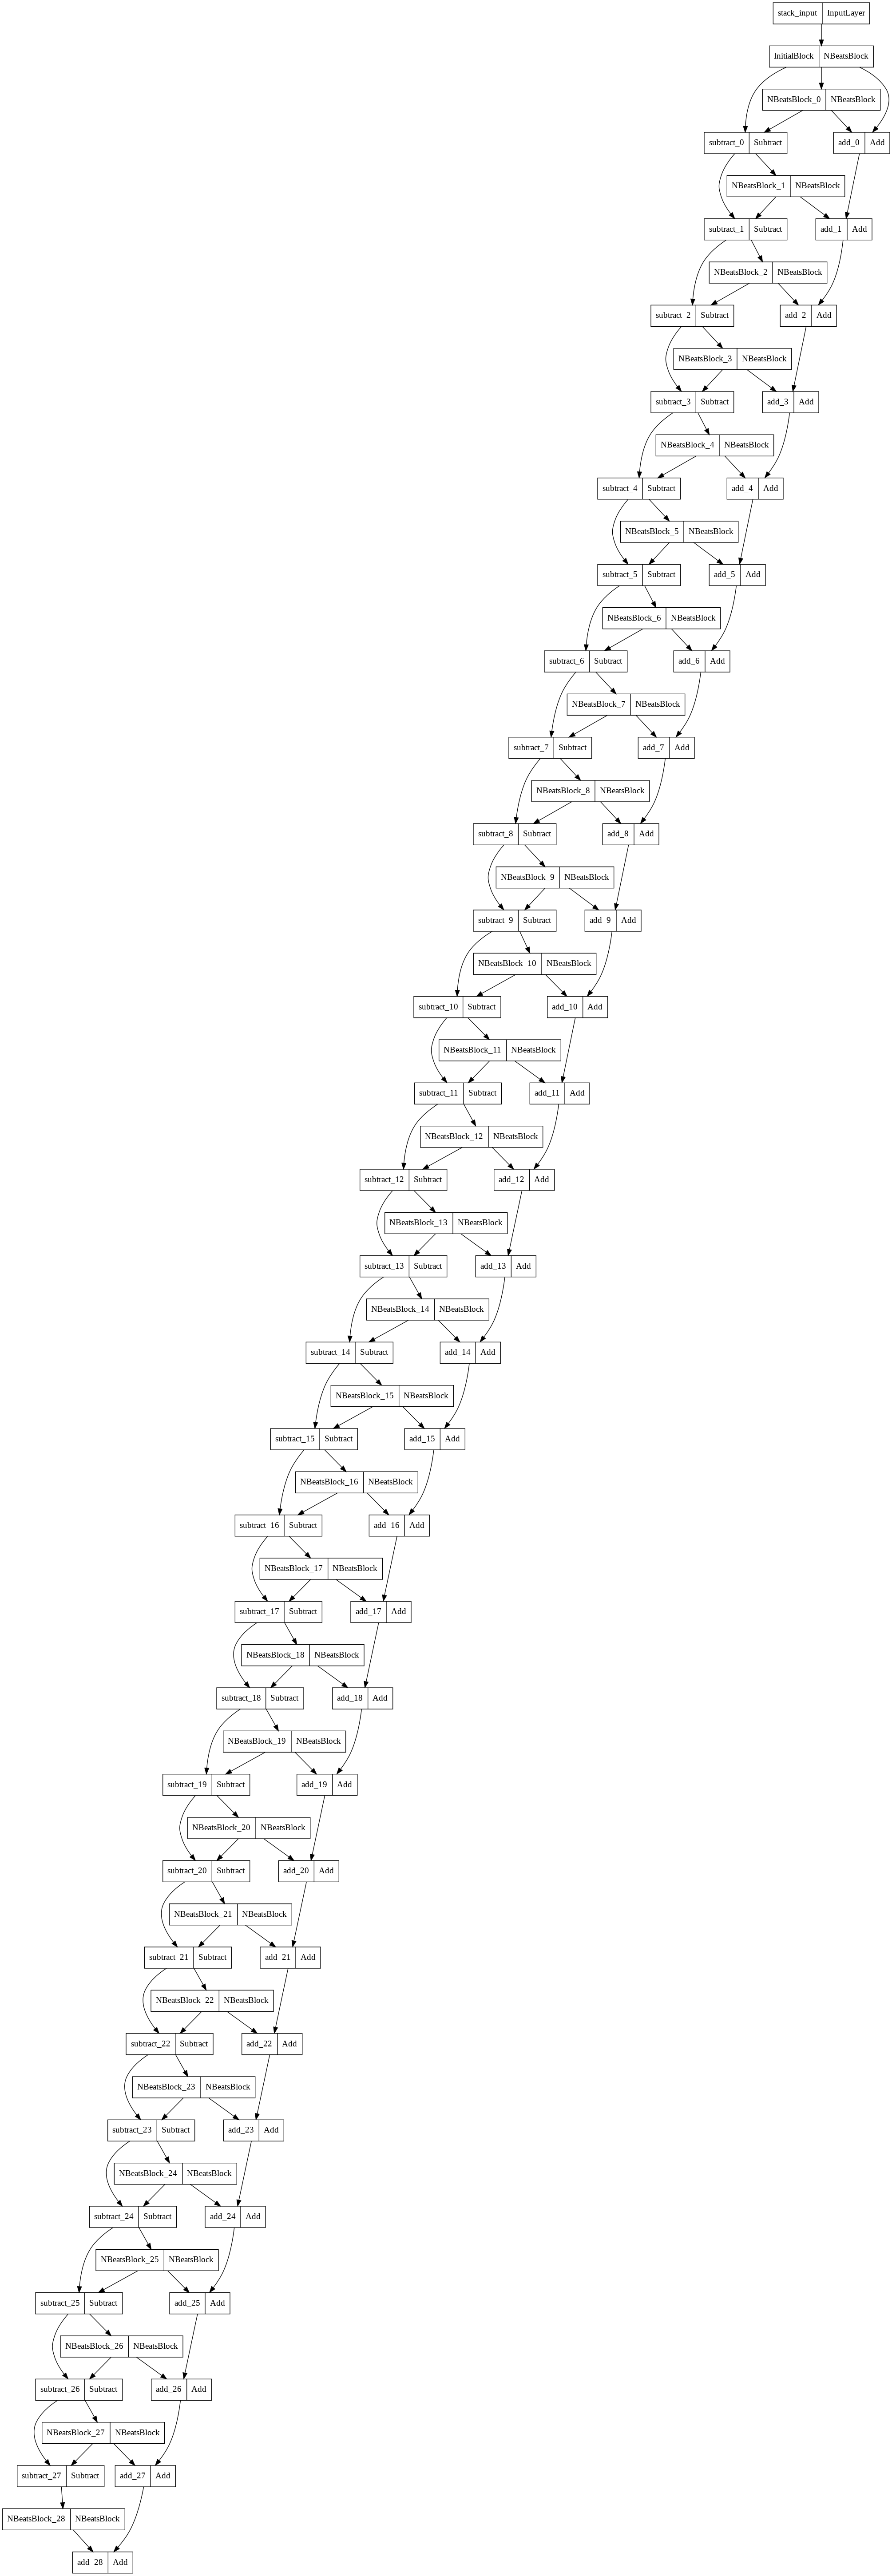

In [92]:
from tensorflow.keras.utils import plot_model

plot_model(model_7)

# Model 8: Building, compiling and fitting an ensemble of models

In [93]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=['mae', 'mse', 'mape']):
    
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f'Optimizing model {i} by reducing {loss_function} for {num_epochs} epochs.')

            # Construct a simple model
            model = tfk.Sequential([
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(HORIZON)                                    
            ])

            # Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=optimizers.Adam(),
                          metrics=['mae', 'mse'])
            
            # Fit the current model
            model.fit(train_data, epochs=num_epochs, verbose=0,
                      validation_data=test_data,
                      callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=200,
                                                             restore_best_weights=True),
                                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                 patience=100,
                                                                 verbose=1)])
            
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)
            
    return ensemble_models

In [94]:
%%time
ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

Optimizing model 0 by reducing mae for 1000 epochs.
Optimizing model 0 by reducing mse for 1000 epochs.

Epoch 506: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 606: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model 0 by reducing mape for 1000 epochs.

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 282: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 382: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model 1 by reducing mae for 1000 epochs.
Optimizing model 1 by reducing mse for 1000 epochs.

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model 1 by reducing mape for 1000 epochs.

Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 740: ReduceLROnPlateau reducing learnin

In [95]:
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []

    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    
    return tf.constant(tf.squeeze(ensemble_preds))

In [96]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models, data=test_dataset)

print(ensemble_preds)

tf.Tensor(
[[ 8763.133  8766.515  9054.852 ... 50434.008 49798.418 46693.977]
 [ 8778.392  8731.986  8985.925 ... 48957.754 48665.03  45455.17 ]
 [ 8732.57   8719.407  9093.386 ... 49921.9   47992.15  45316.45 ]
 ...
 [ 8913.505  8756.962  9027.462 ... 49303.52  49565.73  46414.676]
 [ 8732.24   8813.909  9104.649 ... 49595.434 48532.06  45118.883]
 [ 8823.189  8768.094  9047.36  ... 49764.39  48096.965 45877.88 ]], shape=(15, 556), dtype=float32)


In [97]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)
print(ensemble_results)

{'mae': 580.2, 'mse': 1181326.9, 'rmse': 1086.71, 'mape': 2.66, 'mase': 1.02}


In [98]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_median = np.median(ensemble_preds, axis=0)

ensemble_results_mean = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)
ensemble_results_median = evaluate_preds(y_true=y_test, y_pred=ensemble_median)

print(ensemble_results_mean)
print(ensemble_results_median)

{'mae': 567.58, 'mse': 1144804.1, 'rmse': 1069.96, 'mape': 2.58, 'mase': 1.0}
{'mae': 566.48, 'mse': 1141286.1, 'rmse': 1068.31, 'mape': 2.58, 'mase': 1.0}


# Getting the upper and lower bounds of our prediction intervals

In [99]:
def get_upper_lower(preds):
    """
    Finds upper and lower bounds of ensemble predictions.
    """

    # 1. Take the predictions from a number of randomly initialized models
    
    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96
    interval = 1.96 * std

    # 4. Get the prediction interval upper and lower bound
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper

In [100]:
# Get the upper & lower bounds of the 95% prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

# Plotting the prediction intervals of our ensemble model predictions

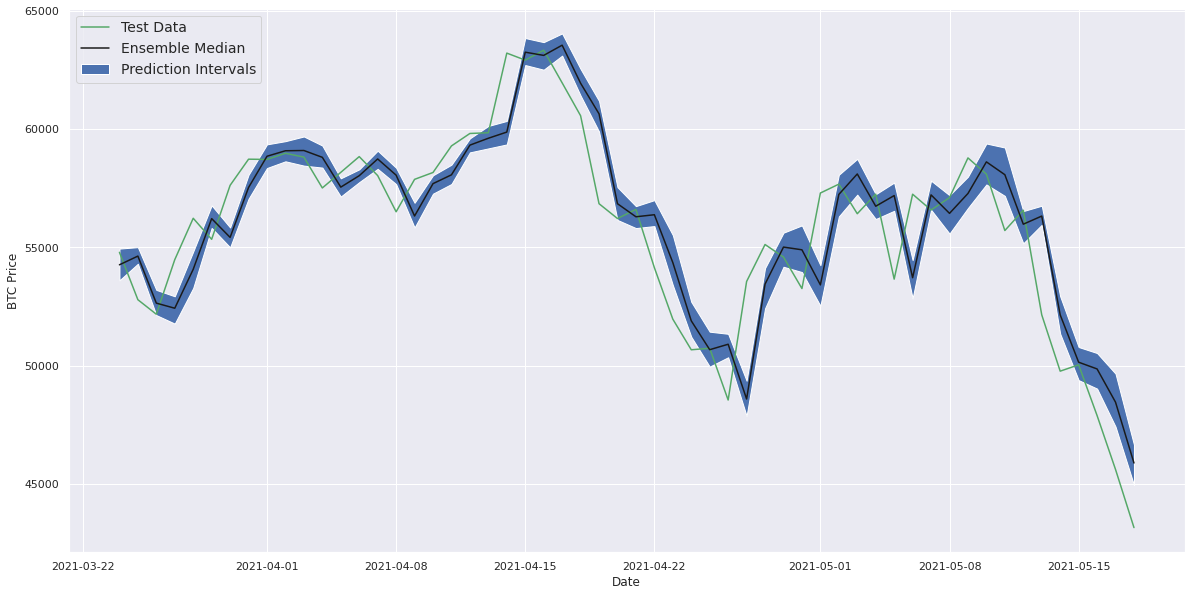

In [101]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
offset = 500
plt.figure(figsize=(20, 10))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Test Data')
plt.plot(X_test.index[offset:], ensemble_median[offset:], 'k-', label='Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.fill_between(X_test.index[offset:],
                (lower)[offset:],
                (upper)[offset:], label='Prediction Intervals')
plt.legend(loc='upper left', fontsize=14)
plt.show()

# Model 9: Preparing data to create a model capable of predicting into the future

In [101]:
bitcoin_prices_windowed

In [103]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.dropna().drop(['Price', 'block_reward'], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

print(X_all.shape, '-', y_all.shape)

(2780, 7) - (2780,)


In [104]:
# Turn  data info efficient running tensors
features_dataset_all = tfd.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tfd.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tfd.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tfd.AUTOTUNE)

print(dataset_all)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


# Model 9: Building, compiling and fitting a future predictions model

In [105]:
tf.random.set_seed(42)

model_9 = tfk.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)                          
], name='model_9_future_model')

model_9.compile(loss=tfk.losses.mae,
                optimizer=optimizers.Adam())

model_9.fit(dataset_all, epochs=100, verbose=0)

# Model 9: Discussing what's required for our model to make future predictions

In [108]:
INTO_FUTURE = 14

# Model 9: Creating a function to make forecasts into the future

In [123]:
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Make future forecasts into_future steps after values ends.
    Returns future forecasts as a list of floats.
    """

    # Create an empty list for future forecast/prepare data to forecast on
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]

    # Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(INTO_FUTURE):
        # Predict on the last window then append it again, again , ...
        # (Model will eventually start to make forecasts on its own forecasts)
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f'Predicting on: {np.round(last_window)}')
        print(f'Prediction:    {np.round(tf.squeeze(future_pred).numpy())}\n')

        # Append predictions to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())
        
        # Update last window with new pred and get WINDOW_SIZE most recent preds
        # (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
    
    return future_forecast

In [124]:
# Make forecasts into the future
future_forecast = make_future_forecasts(values=y_all, model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

Predicting on: [56574. 52148. 49764. 50033. 47886. 45605. 43144.]
Prediction:    55764.0

Predicting on: [52148. 49764. 50033. 47886. 45605. 43144. 55764.]
Prediction:    50986.0

Predicting on: [49764. 50033. 47886. 45605. 43144. 55764. 50986.]
Prediction:    48523.0

Predicting on: [50033. 47886. 45605. 43144. 55764. 50986. 48523.]
Prediction:    48137.0

Predicting on: [47886. 45605. 43144. 55764. 50986. 48523. 48137.]
Prediction:    47881.0

Predicting on: [45605. 43144. 55764. 50986. 48523. 48137. 47881.]
Prediction:    46880.0

Predicting on: [43144. 55764. 50986. 48523. 48137. 47881. 46880.]
Prediction:    48228.0

Predicting on: [55764. 50986. 48523. 48137. 47881. 46880. 48228.]
Prediction:    53964.0

Predicting on: [50986. 48523. 48137. 47881. 46880. 48228. 53964.]
Prediction:    49686.0

Predicting on: [48523. 48137. 47881. 46880. 48228. 53964. 49686.]
Prediction:    47596.0

Predicting on: [48137. 47881. 46880. 48228. 53964. 49686. 47596.]
Prediction:    48114.0

Predicting

# Model 9: Plotting our model's future forecasts

In [125]:
def get_future_dates(start_date, into_future, offset=1):
    """
    Returns array of datetime values ranging from `start_date` to `start_date + into_future`
    """

    start_date = start_date + np.timedelta64(offset, 'D') # 'D': Day
    end_date   = start_date + np.timedelta64(into_future, 'D')

    return np.arange(start_date, end_date, dtype='datetime64[D]')

In [127]:
last_timestep = bitcoin_prices.index[-1]

next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)

print(last_timestep, '\n')
print(next_time_steps)

2021-05-18 00:00:00 

['2021-05-19' '2021-05-20' '2021-05-21' '2021-05-22' '2021-05-23'
 '2021-05-24' '2021-05-25' '2021-05-26' '2021-05-27' '2021-05-28'
 '2021-05-29' '2021-05-30' '2021-05-31' '2021-06-01']


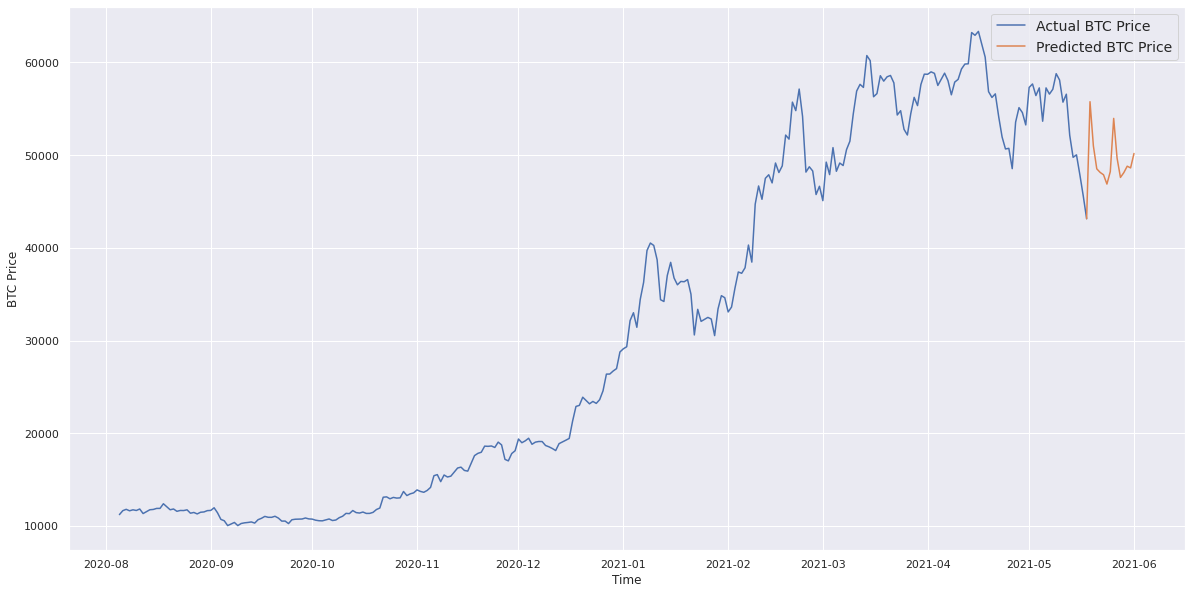

In [129]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

plt.figure(figsize=(20, 10))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format='-', label='Actual BTC Price', y_label='BTC Price')
plot_time_series(next_time_steps, future_forecast, format='-', label='Predicted BTC Price', y_label='BTC Price')

# Model 10: Introducing the turkey problem and making data for it

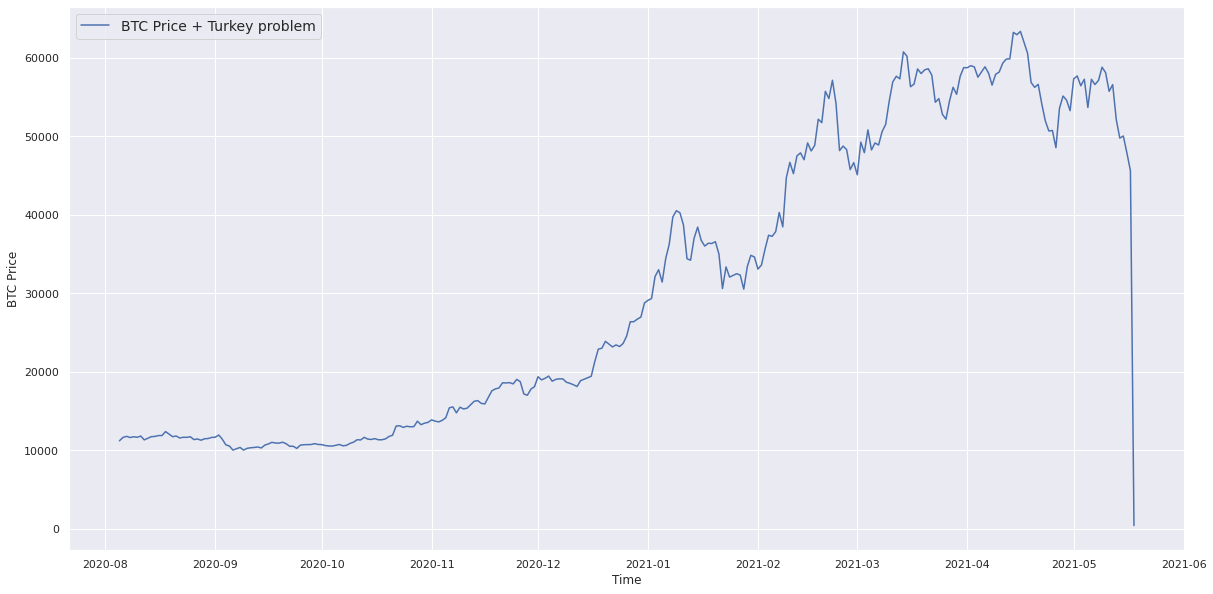

In [131]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

btc_timesteps_turkey = np.array(bitcoin_prices.index) 

plt.figure(figsize=(20, 10))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format='-',
                 label='BTC Price + Turkey problem',
                 start=2500,
                 y_label='BTC Price')

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(np.array(btc_price_turkey), 
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)

# Model 10: Building a model to predict on turkey data (why forecasting is BS)

In [132]:
turkey_model = tfk.models.clone_model(model_1)
turkey_model._name = 'model_10_turkey_model'
turkey_model.compile(loss='mae', optimizer=optimizers.Adam())
turkey_model.fit(X_train, y_train, epochs=100, verbose=0, batch_size=128,
                 validation_data=(X_test,  y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_turkey_model/assets


In [133]:
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 640.7734


640.7734375

In [134]:
turkey_model = tfk.models.load_model('/content/model_experiments/model_10_turkey_model')
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 6ms/step - loss: 567.9632


567.9631958007812

In [135]:
turkey_preds = make_preds(turkey_model, X_test)

print(turkey_preds)

tf.Tensor(
[ 8862.486   8787.992   9051.534   8791.983   8723.428   8739.253
  8701.137   8523.304   8460.945   8540.158   8262.119   8111.326
  8072.999   7686.636   7278.254   7261.9277  7083.887   7166.961
  7131.3257  7472.6797  7428.3555  7691.18    7596.7925  7424.345
  7344.9224  7335.668   7246.193   7363.465   7508.5557  7549.176
  7554.076   7377.217   7263.406   7211.0825  7203.223   7234.509
  7106.6895  7105.126   6920.5493  6623.4062  7299.5327  7238.7334
  7144.4297  7239.295   7293.2876  7213.8433  7217.745   7236.955
  7203.9126  7223.6387  7314.003   7395.752   7282.5513  7192.7275
  7184.837   7002.366   7243.669   7350.1846  7365.197   7663.6997
  8036.809   8120.7725  7859.4814  8061.475   8138.12    8177.8486
  8122.975   8668.073   8893.06    8761.678   8898.357   8989.351
  8731.797   8641.273   8714.802   8677.134   8411.792   8424.936
  8378.049   8545.349   8849.295   9128.423   9326.077   9546.862
  9462.013   9398.548   9409.9375  9321.585   9200.603   9565

In [136]:
turkey_results = evaluate_preds(y_true=y_test, y_pred=turkey_preds)

print(turkey_results)

{'mae': 567.96, 'mse': 1164369.4, 'rmse': 1079.06, 'mape': 2.55, 'mase': 1.0}


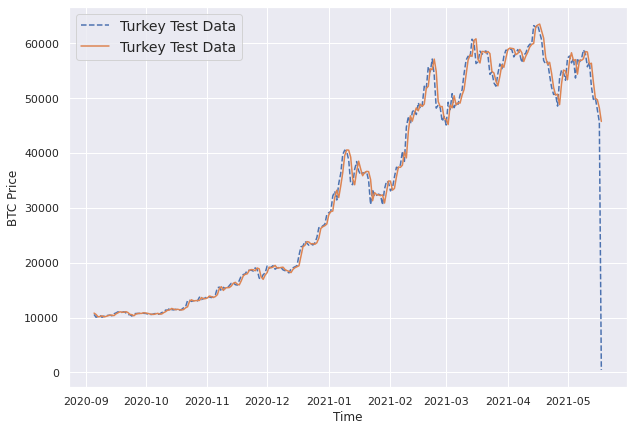

In [141]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format='--',
                 label='Turkey Test Data', y_label='BTC Price', start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, format='-',
                 label='Turkey Test Data', y_label='BTC Price', start=offset)

# Comparing the results of all of our models and discussing where to go next

In [142]:
model_results = pd.DataFrame({'model_1_dense_w7_h1': model_1_results,
                              'model_2_dense_w30_h1': model_2_results,
                              'model_3_dense_w30_h7': model_3_results,
                              'model_4_CONV1D': model_4_results,
                              'model_5_LSTM': model_5_results,
                              'model_6_multivariate': model_6_results,
                              'model_7_NBEATS': model_7_results,
                              'model_8_ensemble': ensemble_results,
                              'model_10_turkey': turkey_results}).T

model_results

,mae,mse,rmse,mape,mase
model_1_dense_w7_h1,568.770020,1174340.625,1083.670044,2.55,1.00
model_2_dense_w30_h1,609.369995,1286932.500,1134.430054,2.74,1.07
model_3_dense_w30_h7,1234.619995,5377565.500,1420.300049,5.51,2.20
model_4_CONV1D,568.760010,1171993.750,1082.589966,2.55,1.00
model_5_LSTM,597.320007,1277204.000,1130.130005,2.69,1.05
model_6_multivariate,567.590027,1161687.250,1077.819946,2.54,1.00
model_7_NBEATS,572.090027,1164190.250,1078.979980,2.57,1.00
model_8_ensemble,580.200012,1181326.875,1086.709961,2.66,1.02
model_10_turkey,567.960022,1164369.375,1079.060059,2.55,1.00


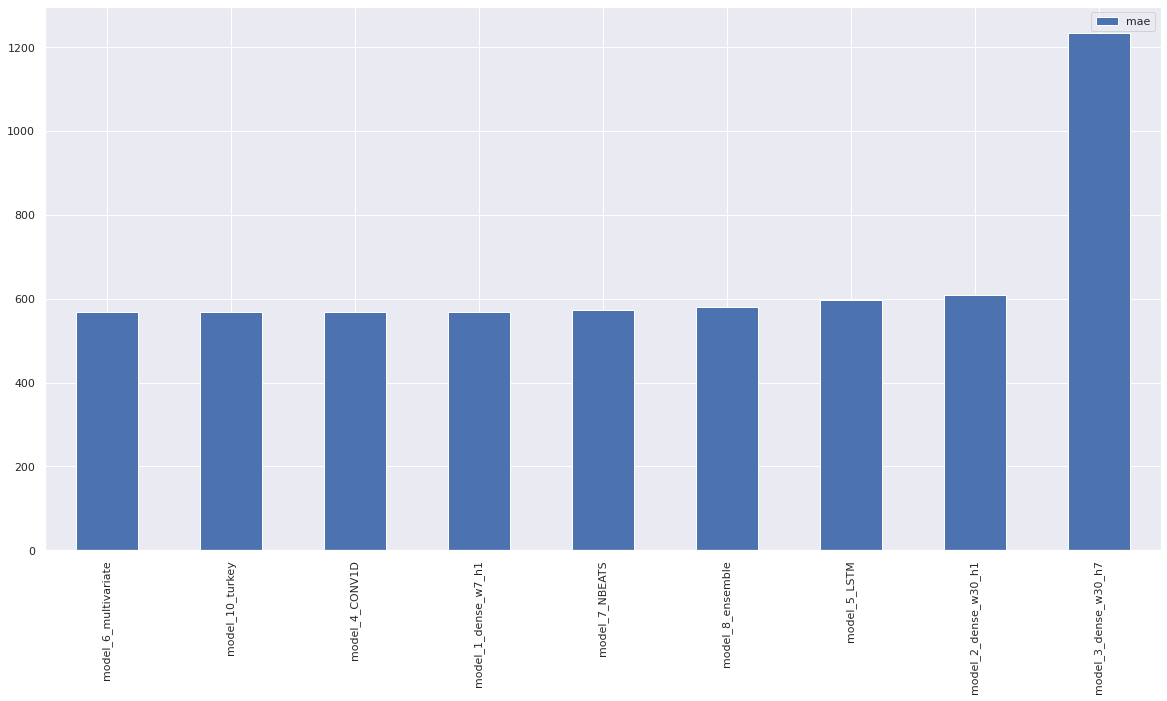

In [144]:
model_results[['mae']].sort_values('mae').plot.bar(figsize=(20, 10));